<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

Goal here is to create figure of enrichment that shows error bars for each catchment around the "null" value.

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")

import scipy
from scipy.spatial import KDTree, cKDTree
from scipy.stats import binom_test

from statsmodels.stats.proportion import proportion_confint
# https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportion_confint.html

In [28]:
# Load cleaned version of data 
all_rds_df = pd.read_csv("C:/Users/jsuresh/Dropbox (IDM)/Malaria Team Folder/projects/Zambia/rcd_enrichment_radius/all_rounds_data_cleaned.csv")
all_rds_df = all_rds_df.sort_values(by=["round","catch"]).reset_index(drop=True)

c:\users\jsuresh\venv\idm\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [29]:
df.groupby("round", "catch")

In [39]:
df["rmin"] = np.tile([0,5,50,100,140],int(len(df)/5))

In [40]:
df["rmax"] = np.tile([5,50,100,140,200],int(len(df)/5))

In [42]:
df.to_csv("save_test.csv", index=False)

In [48]:
foo = df.merge(new_df.rename(columns={"pos_frac": "catch_prev"}), on=["catch", "round"], how="left")

In [50]:
foo.to_csv("catch_round_final.csv", index=False)

In [102]:
foo = foo.dropna()

In [231]:
def weighted_percentile(x,weights,percentile):
    x_new = np.repeat(x,weights.astype("int"))
    p = np.percentile(x_new, percentile)
#     print(p)
    return p

No handles with labels found to put in legend.


0


No handles with labels found to put in legend.


1


No handles with labels found to put in legend.


2


No handles with labels found to put in legend.


3


No handles with labels found to put in legend.


4


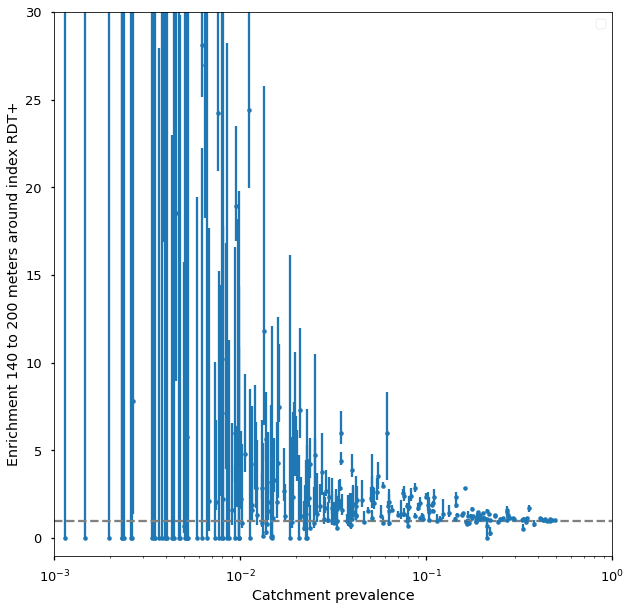

In [246]:
rmin_list = [0,5,50,100,140]
rmax_list = [5,50,100,140,200]

prev_bins = 10**np.arange(-3,0,0.3)
for xscale in ["log"]:
    for i in range(5):
        #     i = 0
        print(i)
        rmin = rmin_list[i]
        rmax = rmax_list[i]

        rcut = foo["rmin"]==rmin
        sdf = foo[rcut]
        yerr_low = np.array(np.abs(sdf["ci_low"]-sdf["center"]))   
        yerr_high = np.array(np.abs(sdf["ci_high"]-sdf["center"]))   
        yerr = np.zeros([2,len(yerr_low)])
        yerr[0,:] = yerr_low
        yerr[1,:] = yerr_high

        plt.close('all')
        plt.figure(figsize=(10,10))

        enrich = sdf["center"]/sdf["catch_prev"]
        enrich_err = np.zeros_like(yerr)
        enrich_err[0,:] = yerr_low/sdf["catch_prev"]
        enrich_err[1,:] = yerr_high/sdf["catch_prev"]
        enrich[enrich<1e-2]=1e-2
#         plt.scatter(sdf["catch_prev"], enrich,marker='.')
        plt.errorbar(sdf["catch_prev"], enrich, enrich_err,marker='.', linestyle="none")
        plt.xlabel("Catchment prevalence") 
        plt.ylabel("Enrichment {} to {} meters around index RDT+".format(rmin, rmax))

        if xscale == "log":
            plt.xscale("log")
            plt.xlim([1e-3,1])
#             plt.yscale("log")
#             plt.ylim([1e-2,1e2])
            plt.ylim([-1,30])
            plt.axhline(1, color='gray', linestyle='dashed')

        if False:
            xx = (prev_bins[:-1]+prev_bins[1:])/2
            yy = np.array([])
            yy_err = np.array([])

            yy_20 = np.array([])
            yy_80 = np.array([])
            yy_median = np.array([])

            yy_weighted_20 = np.array([])
            yy_weighted_80 = np.array([])
            yy_weighted_median = np.array([])

            for pi in np.arange(len(prev_bins)):
                if pi > 0:
                    prev_cut = np.logical_and(sdf["catch_prev"] >= prev_bins[pi-1], sdf["catch_prev"] < prev_bins[pi])

                    # Mean and stdev
                    yy = np.append(yy, np.mean(enrich[prev_cut]))
                    yy_err = np.append(yy_err, np.std(enrich[prev_cut]))

                    # Unweighted median + percentiles (treats each point with equal weight)
                    yy_median = np.append(yy_median, np.median(enrich[prev_cut]))
                    yy_20 = np.append(yy_20, np.percentile(enrich[prev_cut],20))
                    yy_80 = np.append(yy_80, np.percentile(enrich[prev_cut],80))

                    # Weighted median + percentiles (larger populations have higher weight)
                    w = sdf[prev_cut]["n_pos"]
                    yy_weighted_median = np.append(yy_weighted_median, weighted_percentile(enrich[prev_cut],w, 50))
                    yy_weighted_20 = np.append(yy_weighted_20, weighted_percentile(enrich[prev_cut],w,20))
                    yy_weighted_80 = np.append(yy_weighted_80, weighted_percentile(enrich[prev_cut],w,80))

            plt.errorbar(xx,yy,yy_err, color='C1', label="mean and stdev")
            plt.fill_between(xx,yy-yy_err, yy+yy_err, alpha=0.2)

            plt.plot(xx,yy_median, color='C3', label="unweighted median and 20-80 percentiles")
            plt.fill_between(xx, yy_20, yy_80, color='C3', alpha=0.3)

            plt.plot(xx,yy_weighted_median, color='C4', label="weighted median and 20-80 percentiles")
            plt.fill_between(xx, yy_weighted_20, yy_weighted_80, color='C4', alpha=0.3)

        plt.legend()
        plt.savefig("binom_err_allcatch_r{}_{}_v3.png".format(rmin, rmax))
            

In [192]:
np.arange(-3,0,0.1)

array([-3. , -2.9, -2.8, -2.7, -2.6, -2.5, -2.4, -2.3, -2.2, -2.1, -2. ,
       -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1. , -0.9,
       -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1])

0
1
2
3
4


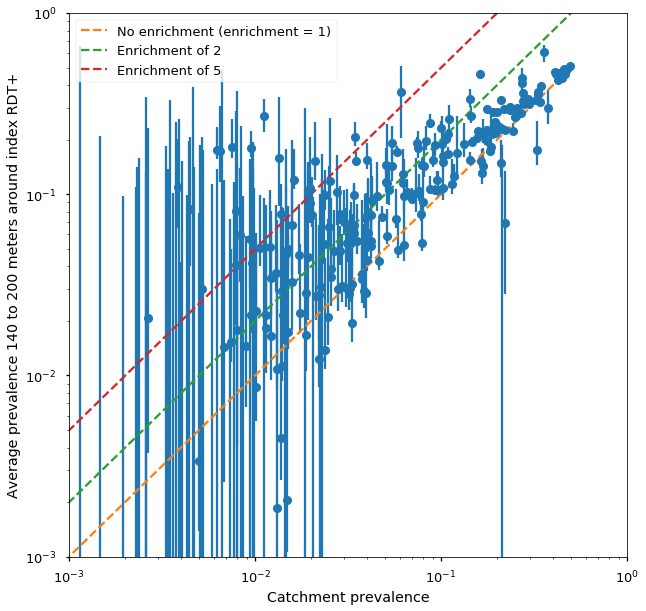

In [252]:
rmin_list = [0,5,50,100,140]
rmax_list = [5,50,100,140,200]

for i in range(len(rmin_list)):
    print(i)
    rmin = rmin_list[i]
    rmax = rmax_list[i]
    
    rcut = foo["rmin"]==rmin
    sdf = foo[rcut]
    # plt.scatter(sdf["catch_prev"], sdf["center"], marker='.')
    yerr_low = np.array(np.abs(sdf["ci_low"]-sdf["center"]))   
    yerr_high = np.array(np.abs(sdf["ci_high"]-sdf["center"]))   
    yerr = np.zeros([2,len(yerr_low)])
    yerr[0,:] = yerr_low
    yerr[1,:] = yerr_high

    # yerr = np.array(sdf[["ci_low", "ci_high"]]).T

    # yerr = np.array(sdf[["ci_low", "ci_high"]]).T
    plt.close('all')
    plt.figure(figsize=(10,10))
    plt.errorbar(sdf["catch_prev"], sdf["center"], yerr = yerr, ls="none", marker='o')
    plt.plot([0,0.5], [0,0.5], linestyle='dashed', label="No enrichment (enrichment = 1)")
    plt.plot([0,0.5], [0,1], linestyle='dashed', label="Enrichment of 2")
    plt.plot([0,0.5], [0,2.5], linestyle='dashed', label="Enrichment of 5")
    plt.xlabel("Catchment prevalence") 
    plt.ylabel("Average prevalence {} to {} meters around index RDT+".format(rmin, rmax))
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim([1e-3,1])
    plt.ylim([1e-3,1])
    plt.legend()
    plt.savefig("binom_err_allcatch_r{}_{}_loglog.png".format(rmin, rmax))

0
[4.38634499e-02 9.10421734e+00 4.93832529e-01 1.14791508e-01
 2.77778976e-02 1.08202353e+01 1.05684928e+01 8.33449256e+00
 1.20792853e-01 1.22602025e+01 1.23172200e+01 2.30868432e-02
 1.47927855e+01 4.42174167e+00 2.51528753e-03 1.38071578e-01
 1.16103485e-02 1.31397787e+01 1.57181747e-01 1.55927522e+01
 2.37923822e-02 1.57784899e-02 6.96859044e+00 4.93562336e-01
 4.08254217e+00 2.80720055e-02 9.23428391e+00 2.50101966e-02
 5.12381326e+00 9.33994962e-02 6.68571989e+00 6.80775083e+00
 5.04992249e-02]
23.91846064937631
152.11825723809383
0 [0.0025 0.0075 0.03   0.075  0.15   0.25   0.35   0.45  ] [0.15723596 0.         0.         0.         0.         0.
 0.         0.        ]
[ 0.16074662  0.13533982  0.07992105  0.16833444  0.82867802  0.13622445
  0.08388726  0.12399487  0.10718168  0.18591512  7.40484883  0.10940464
 11.36410686  0.8199553  11.98241315  0.14402669  0.55443104 15.42214094
  0.18548294  0.05951741  0.044243    0.08271513  5.12381326  0.69445063
  0.33976051  0.24685

[2.49960421e+01 1.46575606e+01 1.70574268e+01 1.97568503e+01
 1.21707635e+01 4.69778963e-02 9.80953315e+00 1.37293292e+01
 1.49400123e-01 9.74512294e+00 7.75106307e-02 8.56188349e+00
 3.38157118e-02 1.51437303e+01 2.57322462e+01 5.64444880e+00
 9.44166761e+00 8.24762652e+00 3.65904735e-02 1.17092821e+01
 1.53486618e+01 6.29966137e+00 2.14782263e-02 8.25748508e+00
 6.90310824e+00 4.31985910e-02]
9.527891475691108
243.62140185282828
0 [0.0025 0.0075 0.03   0.075  0.15   0.25   0.35   0.45  ] [0.03910942 0.         0.         0.         0.         0.
 0.         0.        ]
[1.46870770e+00 5.58219525e-01 1.17111083e+01 1.84893867e+00
 2.49242180e+01 7.35046189e-02 2.27495441e-01 3.46835563e-01
 7.89591357e-01 2.11007883e+01 5.64444880e+00 4.43211851e-01
 9.85046609e+00 7.69237292e-01 1.43983738e+01 2.75111416e+01
 9.95139753e+00 7.40563107e+00 1.72148398e-01 1.30185918e-01
 1.51936048e+01 9.65053094e-01 7.13461399e+00 2.41936985e+01
 2.13502275e+01 6.20126390e-02 1.15665479e+01 2.56139946

4
[18.22009842 14.16324597 20.23186501 25.29475187 19.67989472 20.47255545
  5.84930505 47.29529226 14.24286594 13.08411145 15.25511927  0.07159804
 10.16659698  0.14257024  5.12381326 10.85264911  7.68168015  6.02455434
 14.59352706 12.70533418  2.00016985  3.04127109  0.05016852  5.12381326
  9.57663957  7.97293768]
5.229830027747104
308.9164287456245
0 [0.0025 0.0075 0.03   0.075  0.15   0.25   0.35   0.45  ] [0.0169296 0.        0.        0.        0.        0.        0.
 0.       ]
[ 0.74495689  0.23204361 14.25669902  0.32270158 27.26003957  0.54051723
  0.52963452  0.25733504 35.82154151 18.169531    9.69854348  0.24805649
 14.4861981   0.7946979  16.77951418 10.67823932  8.40924705 11.42364852
 17.13714321  0.09675391 20.56500828  4.11509805  0.82729544  5.3547292
 51.22291629 18.60220519  0.06487935 17.53552314  0.05640368  0.12475689
  0.073392   10.31786577  0.19707701]
22.161069646178237
316.9441924539787
1 [0.0025 0.0075 0.03   0.075  0.15   0.25   0.35   0.45  ] [0.016929

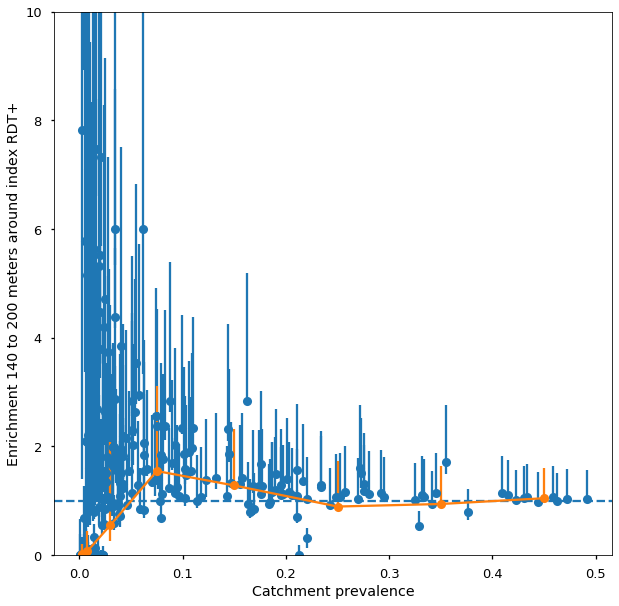

In [158]:
rmin_list = [0,5,50,100,140]
rmax_list = [5,50,100,140,200]

prevmin_list = [0,0.005,0.01,0.05,0.1,0.2,0.3,0.4]
prevmax_list = [0.005,0.01,0.05,0.1,0.2,0.3,0.4,0.5]
for i in range(len(rmin_list)):
    print(i)
    rmin = rmin_list[i]
    rmax = rmax_list[i]
    
    rcut = foo["rmin"]==rmin
    sdf = foo[rcut]
    
    x = sdf["catch_prev"]
    y = sdf["center"]/sdf["catch_prev"]
    
    # plt.scatter(sdf["catch_prev"], sdf["center"], marker='.')
    yerr_low = np.array(np.abs(sdf["ci_low"]-sdf["center"])/sdf["catch_prev"])
    yerr_high = np.array(np.abs(sdf["ci_high"]-sdf["center"]/sdf["catch_prev"]))   
    yerr = np.zeros([2,len(yerr_low)])
    yerr[0,:] = yerr_low
    yerr[1,:] = yerr_high

    # yerr = np.array(sdf[["ci_low", "ci_high"]]).T

    # yerr = np.array(sdf[["ci_low", "ci_high"]]).T
    plt.close('all')
    plt.figure(figsize=(10,10))
    plt.errorbar(sdf["catch_prev"], sdf["center"]/sdf["catch_prev"], yerr = yerr, ls="none", marker='o')
    plt.axhline(1, linestyle='dashed')
    plt.ylim([0,10])
    plt.xlabel("Catchment prevalence") 
    plt.ylabel("Enrichment {} to {} meters around index RDT+".format(rmin, rmax))
    
    # Plot binned trend line with error bars
    xx = (np.array(prevmin_list) + np.array(prevmax_list))/2
    yy = np.zeros_like(xx)
    yy_hi = np.zeros_like(xx)
    yy_lo = np.zeros_like(xx)
    
    for j in range(len(prevmin_list)):
        prevcut = np.logical_and(sdf["catch_prev"] >= prevmin_list[j],
                                 sdf["catch_prev"] < prevmax_list[j])
        ssdf = sdf[prevcut]
        
        c,lo,hi = weighted_avg_with_error(y[prevcut], yerr_low[prevcut], yerr_high[prevcut])
        yy[j] = c
        yy_lo[j] = lo
        yy_hi[j] = hi
        
        print(j,xx,yy)
    plt.errorbar(xx,yy,yerr = np.array([yy_lo, yy_hi]),color='C1', marker='o')
    plt.savefig("binom_enrich_allcatch_r{}_{}.png".format(rmin, rmax))
        
        

In [138]:
j=4
print(prevmin_list[j])
prevcut = np.logical_and(sdf["catch_prev"] >= prevmin_list[j],
                         sdf["catch_prev"] < prevmax_list[j])
ssdf = sdf[prevcut]

c,lo,hi = weighted_avg_with_error(y[prevcut], yerr_low[prevcut], yerr_high[prevcut])
yy[j] = c
yy_lo[j] = lo
yy_hi[j] = hi



0.2


In [149]:
weighted_avg_with_error(y[prevcut], yerr_low[prevcut], yerr_high[prevcut])

[  4.92621887   6.08896328   3.44497551   5.20056875   4.39138723
   3.82378345  29.49459863   5.9844959    5.07129596   5.84881627
   4.25127476   5.18680914   6.42253758   5.96494942   6.08920947
   6.82405038   2.8456494  113.40311284   4.22667713   2.36594649
   3.02536247   7.56406123  10.57834211   2.44076266]
135.29019899736554
255.46384895226586


(0.5295864739853853, 0.01633363864524305, 0.17554554630003688)

In [150]:
y[prevcut]

214     1.104555
264     1.069096
274     1.359584
359     1.181211
364     1.165877
374     1.299984
509     0.315629
549     1.118693
554     1.094988
574     1.142924
614     1.308937
629     1.161203
714     1.069858
859     1.026080
1004    1.075175
1029    1.040864
1089    1.605519
1149    0.000000
1174    1.248064
1274    1.513889
1324    1.409806
1354    0.925191
1359    0.703044
1364    1.566986
dtype: float64

In [157]:
def weighted_avg_with_error(x, dx_low, dx_high):
    sigma = (dx_high + dx_low)/2. # average upper/lower error to get estimate for stdev
    v = sigma**2
    w = 1/sigma
    center = np.sum(w*x)/np.sum(w)
#     center = np.mean(x) # TESTING ONLY
    
#     print(x)
#     print(sigma)
    print(w)
    
    print(np.sum(w*x))
    print(np.sum(w))
    dx_center_high = np.median(dx_high)
    dx_center_low = np.median(dx_low)
#     dx_center_high = (1/len(dx_high)) * np.sqrt(np.sum(dx_high**2))
#     dx_center_low = (1/len(dx_low)) * np.sqrt(np.sum(dx_low**2))
    
    return center, dx_center_low, dx_center_high
    
    
# # Make a binned version which preserves error bars correctly
# prevbins_min = np.array([0,0.005,0.01,0.05,0.1,0.2,0.3,0.4])
# prevbins_max = np.array([0.005,0.01,0.05,0.1,0.2,0.3,0.4,0.5])

# for j in range(len(prevbins_min)):
    

In [107]:
sdf = foo[np.logical_and(foo["rmin"]==140, foo["catch_prev"]>0.4)]
print(sdf)

            catch  round    center    ci_low   ci_high  rmin  rmax  n_obs  \
354        Luumbo      1  0.426352  0.405200  0.452830   140   200    717   
369        Luumbo      4  0.461525  0.453931  0.470071   140   200   4788   
544       Chiyabi      1  0.490940  0.484271  0.498041   140   200   2919   
559       Chiyabi      4  0.464767  0.458876  0.471574   140   200   3558   
569       Chiyabi      6  0.438422  0.431668  0.447614   140   200   3274   
999    Sinamalima      1  0.511522  0.509004  0.513969   140   200   9951   
1154  Chabbobboma      1  0.449094  0.444095  0.454590   140   200   7422   
1169  Chabbobboma      4  0.488514  0.483439  0.494230   140   200   6707   
1299     Sinafala      1  0.458472  0.452656  0.465181   140   200   3965   
1314     Sinafala      4  0.469873  0.464441  0.475997   140   200   4079   

       n_pos  catch_prev  
354    303.0    0.422594  
369   1988.0    0.415205  
544   1379.0    0.472422  
559   1541.0    0.433108  
569   1454.0    0

In [108]:
yerr_low = np.array(np.abs(sdf["ci_low"]-sdf["center"])/sdf["catch_prev"])
yerr_high = np.array(np.abs(sdf["ci_high"]-sdf["center"]/sdf["catch_prev"]))   
weighted_avg_with_error(sdf["center"]/sdf["catch_prev"], yerr_low, yerr_high)

1.0450265031331074 0.006382499513326087 0.18295010378759366


In [88]:
yerr_low = np.array(np.abs(sdf["ci_low"]-sdf["center"]))   
yerr_high = np.array(np.abs(sdf["ci_high"]-sdf["center"]))   
yerr = np.zeros([2,len(yerr_low)])
yerr[0,:] = yerr_low
yerr[1,:] = yerr_high

In [86]:
yerr = np.zeros([2,len(yerr_low)])

In [89]:
yerr

array([[6.42128334e-03, 6.85517390e-03, 2.95067204e-03, 5.86643432e-03,
        4.74165396e-03, 9.80395093e-04, 5.11195779e-03, 1.05605650e-02,
        9.35553565e-03, 4.57206659e-03, 1.85557557e-02, 8.98582207e-03,
        7.05136038e-03, 8.31422974e-03, 6.23658315e-03, 1.06587188e-02,
        2.62289941e-02, 3.92523115e-18, 3.40948657e-02, 3.08395285e-18,
        2.77730644e-02, 4.87622174e-02, 1.38984931e-02, 1.98216390e-02,
        1.83435306e-03, 1.60128321e-18, 0.00000000e+00, 6.52736450e-03,
        7.75791923e-18, 8.61991025e-19, 8.84741272e-03, 1.41902997e-02,
        1.17177519e-02, 4.90339322e-02, 1.36812053e-02, 2.15049209e-02,
        1.15580439e-03, 2.69845874e-18, 6.23246361e-03, 9.33718658e-03,
        5.28756342e-03, 5.92992225e-03, 7.63585848e-03, 6.19503440e-03,
        5.59961604e-03, 7.26847913e-03, 5.16735674e-03, 5.95606392e-03,
        1.29724789e-02, 1.80838821e-02, 2.00148302e-18, 8.17789634e-03,
        3.00915983e-03, 6.21813417e-03, 3.95310072e-03, 3.534020

In [253]:
foo

,catch,round,center,ci_low,ci_high,rmin,rmax,n_obs,n_pos,catch_prev
0,Mtendere,1,0.264383,0.253302,0.283771,0,5,9492,552.0,0.058154
1,Mtendere,1,0.203363,0.193248,0.223931,5,50,9492,552.0,0.058154
2,Mtendere,1,0.185907,0.178241,0.202481,50,100,9492,552.0,0.058154
3,Mtendere,1,0.198786,0.190561,0.213753,100,140,9492,552.0,0.058154
4,Mtendere,1,0.171686,0.165264,0.185323,140,200,9492,552.0,0.058154
5,Mtendere,2,0.202461,0.192913,0.222879,0,5,10797,369.0,0.034176
6,Mtendere,2,0.081534,0.073366,0.110784,5,50,10797,369.0,0.034176
7,Mtendere,2,0.097726,0.089732,0.120105,50,100,10797,369.0,0.034176
8,Mtendere,2,0.108896,0.100483,0.130136,100,140,10797,369.0,0.034176
9,Mtendere,2,0.098444,0.091589,0.114707,140,200,10797,369.0,0.034176


In [266]:
lat_cut = np.logical_and(all_rds_df["latitude"] > -16.85, all_rds_df["latitude"] < -16.76)
lon_cut = np.logical_and(all_rds_df["longitude"] > 26.95, all_rds_df["longitude"] < 27.02)
round_cut = all_rds_df["round"]==9
fix = all_rds_df[np.logical_and.reduce([round_cut, lat_cut, lon_cut])]

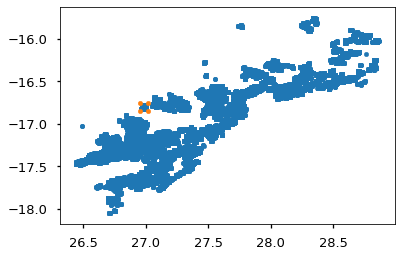

In [265]:
plt.scatter(fix["longitude"], fix["latitude"], marker='.')
plt.scatter([26.95, 27.02,26.95, 27.02],[-16.76,-16.76,-16.85, -16.85], marker='.')

# plt.xlim([26.94, 27.06])
# plt.ylim([-16.74,-16.86])

In [271]:
fixed = all_rds_df.copy(deep=True)

In [272]:
fixed.loc[np.logical_and.reduce([round_cut, lat_cut, lon_cut]), "latitude"] = np.nan

In [273]:
fixed.loc[np.logical_and.reduce([round_cut, lat_cut, lon_cut]), "longitude"] = np.nan

In [275]:
fixed[np.logical_and.reduce([round_cut, lat_cut, lon_cut])]

,person_id,household_id,round,latitude,longitude,catch,rdt_pos,x,y
728410,uuid:03d9edd4-5cc2-4c18-ae09-7efb7db99ba8,56765.0,9,NaN,NaN,Batoka,1.0,-51016.915761,17033.677872
728474,uuid:0638cb7b-0332-4357-9b03-bdbd427867c5,33585.0,9,NaN,NaN,Batoka,0.0,-48440.926810,19009.520580
728482,uuid:067154eb-2c87-4a2a-92fe-347397ab785f,56781.0,9,NaN,NaN,Batoka,0.0,-51022.762262,17040.856825
728538,uuid:0885b172-aa11-4e0a-93ab-ca1709577b01,42373.0,9,NaN,NaN,Batoka,1.0,-51017.745195,17035.961022
728542,uuid:089e37d0-6f68-4e00-9002-5028eac27ede,69483.0,9,NaN,NaN,Batoka,0.0,-48440.162324,19026.847358
728632,uuid:0b3eedf5-a9a7-4a3b-92bf-82e5295ea2fe,56773.0,9,NaN,NaN,Batoka,1.0,-51016.348253,17034.408124
728663,uuid:0c91f8a4-ab64-4058-b3eb-c8e00a0a7bdc,56786.0,9,NaN,NaN,Batoka,1.0,-51030.016352,17043.564099
728864,uuid:130d1a02-f31e-4778-8520-90bcb57d2556,33600.0,9,NaN,NaN,Batoka,0.0,-50890.707577,18105.165170
728913,uuid:145fc0e0-e84a-4c46-bcf9-ef92899bc6a8,33601.0,9,NaN,NaN,Batoka,0.0,-50886.625355,18109.828316
728968,uuid:16376ac8-01c0-4851-ab7a-25a779ef9192,33590.0,9,NaN,NaN,Batoka,0.0,-48443.482191,19015.902490


In [276]:
fixed.to_csv("all_rounds_data_cleaned.csv", index=False)